In [1]:
import sys
sys.path.append("../utils")
from utils import load_data, load_cgc_data, set_random_seed
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from vae import create_ae_model

2024-12-03 15:30:10.852433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
set_random_seed(42)

# Can be used with both CGC and non CGC column selection 
Be careful with the comments

In [3]:
train_data, test_data, train_target = load_data(raw = False, categorical=False)
#train_data, test_data, train_target = load_cgc_data()

In [4]:
nb_cell_lines = train_data.shape[0]
print("Number of cell lines: ", nb_cell_lines)

Number of cell lines:  742


In [5]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2)

In [ ]:
# Parameters
input_dim = X_train.shape[1]
latent_dim = 50  # Adjust the latent dimension as needed
batch_size = 32
epochs = 20

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


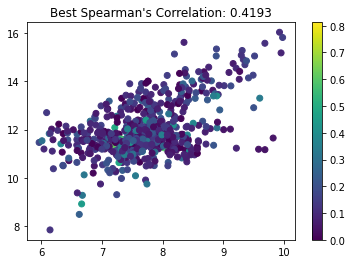

In [ ]:
set_random_seed(42)
autoencoder = create_ae_model(input_dim=input_dim, latent_dim=latent_dim)
autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=False, validation_data=(X_test, X_test), verbose=0)

# Use encoder part of the autoencoder for feature extraction
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)


# Plot the best latent features
plt.scatter(encoded_features_train[:, 0], encoded_features_train[:, 1], c=y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.title(f"Best Spearman's Correlation: {spearman_encoded:.4f}")
plt.show()

In [11]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
total_data = pd.concat([train_data, test_data])
encoded_features = encoder.predict(total_data)
print(encoded_features.shape)
encoded_features = pd.DataFrame(encoded_features, columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
#encoded_features.to_csv(data_path / 'ae_data.csv', index=False)
encoded_features.to_csv(data_path / 'ae_cgc_data.csv', index=False)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1046, 50)


# VAE

In [13]:
from src.utils.vae import VAE, train, plot_latent_space, load_vae_model, save_vae_model
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Epoch 1/10, Train Loss: 2.6108, Val Loss: 1.4643
Epoch 2/10, Train Loss: 0.6611, Val Loss: 0.2478
Epoch 3/10, Train Loss: 0.1766, Val Loss: 0.0904
Epoch 4/10, Train Loss: 0.0760, Val Loss: 0.0493
Epoch 5/10, Train Loss: 0.0464, Val Loss: 0.0312
Epoch 6/10, Train Loss: 0.0329, Val Loss: 0.0232
Epoch 7/10, Train Loss: 0.0249, Val Loss: 0.0214
Epoch 8/10, Train Loss: 0.0207, Val Loss: 0.0165
Epoch 9/10, Train Loss: 0.0165, Val Loss: 0.0135
Epoch 10/10, Train Loss: 0.0135, Val Loss: 0.0117
(593, 50)
--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.006666077003476802
R-squared (R²): 0.10953700471558181
Spearman's Correlation (ρ): 0.3512500918286333


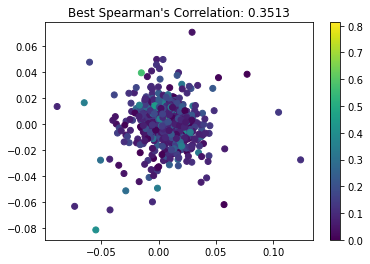

In [16]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_random_seed(42)
batch_size = 32
epochs = 10
input_dim = X_train.shape[1]
latent_dim = 50
# Convert to tensor
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader, test_loader, optimizer, epochs=epochs, device=device)

# Extract latent features from X_train
latent_train, _ = model.encode(X_train_tensor)
latent_test, _ = model.encode(X_test_tensor)
latent_train = latent_train.detach().numpy()
latent_test = latent_test.detach().numpy()
print(latent_train.shape) 

# Train a linear regression model on the encoded features
vae_encoded_model = LinearRegression()
vae_encoded_model.fit(latent_train, y_train)
y_pred_vae = vae_encoded_model.predict(latent_test)

# Calculate regression metrics
mse_vae = mean_squared_error(y_test, y_pred_vae)
r2_vae = r2_score(y_test, y_pred_vae)
spearman_vae, p_value_vae = spearmanr(y_test, y_pred_vae)

# Print the results
print("--- VAE Encoded Features ---")
print("Mean Squared Error (MSE):", mse_vae)
print("R-squared (R²):", r2_vae)
print("Spearman's Correlation (ρ):", spearman_vae)
        


# Plot only the best latent features
plt.scatter(latent_train[:, 0], latent_train[:, 1], c=y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.title(f"Best Spearman's Correlation: {spearman_vae:.4f}")
plt.show()

In [12]:
total_data = pd.concat([train_data, test_data])
total_data_tensor = torch.tensor(total_data.values, dtype=torch.float32)
best_model = load_vae_model(file_name='vae_cgc_model_0_4342.pth')
encoded_features,_ = best_model.encode(total_data_tensor)
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'encoded'
encoded_features = pd.DataFrame(encoded_features.detach().numpy(), columns=["encoded_feature_" + str(i) for i in range(encoded_features.shape[1])])
#encoded_features.to_csv(data_path / 'vae_data.csv', index=False)
encoded_features.to_csv(data_path / 'vae_cgc_data.csv', index=False)

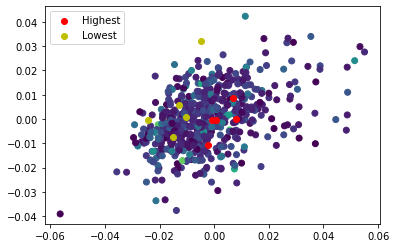

In [ ]:
# PLot the 5 values with the highest and lowest values of AAC
# Sort the predictions
sorted_indices = np.argsort(y_train['AAC'].values)
# Get the 5 highest and lowest values
highest_indices = sorted_indices[-5:]
lowest_indices = sorted_indices[:5]
latent_x = 0
latent_y = 1
# Plot the values in latent space
plt.scatter(latent_train[:, latent_x], latent_train[:, latent_y], c=y_train['AAC'], cmap='viridis')
plt.scatter(latent_train[highest_indices, latent_x], latent_train[highest_indices, latent_y], c='r', label='Highest')
plt.scatter(latent_train[lowest_indices, latent_x], latent_train[lowest_indices, latent_y], c='y', label='Lowest')
plt.legend()
plt.show()
